In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Читаем данные
df = pd.read_csv('mini_example.log', sep='\t', 
                 names=['type', 'address', 'thread_id', 'return_addr'])

In [3]:
mini_df = pd.read_csv('mini_example.log', sep='\t', 
                 names=['type', 'address', 'thread_id', 'return_addr'])

In [3]:
# НЕ ЗАПУСКАТЬ НА БОЛЬШИХ ДАННЫХ

import plotly.graph_objects as go

# Добавляем временную метку (порядковый номер)
df['timestamp'] = range(len(df))

fig = go.Figure()
fig.add_trace(go.Scatter(
    x=df['timestamp'],
    y=df['address'],
    mode='markers',
    marker=dict(
        size=8,
        color=df['thread_id'],
        colorscale='Viridis'
    )
))

fig.update_layout(
    title='Memory Access Pattern over Time',
    xaxis_title='Access Sequence',
    yaxis_title='Memory Address'
)
fig.show()

Работает только на небольших примерах

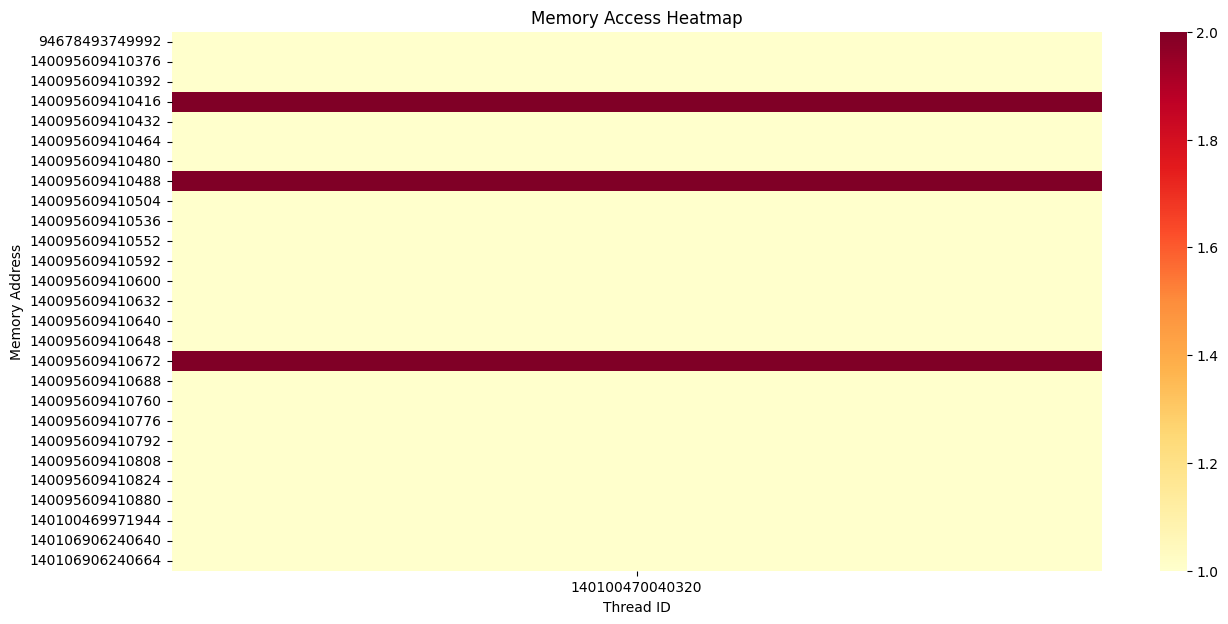

In [4]:
# Создаем pivot table напрямую из исходного DataFrame
heat_data = pd.pivot_table(df, 
                          values='return_addr',  # можно использовать любую колонку как values
                          index='address',
                          columns='thread_id',
                          aggfunc='count')  # подсчет количества

# Создаем тепловую карту
plt.figure(figsize=(15, 7))
sns.heatmap(heat_data, cmap='YlOrRd')
plt.title('Memory Access Heatmap')
plt.xlabel('Thread ID')
plt.ylabel('Memory Address')
plt.show()


Heat-мапа доступов к памяти по потокам и адрессам, к которым был осуществлён доступ. 

На большом примере не особо информативно, но есть файл example2.log. Там миллионы доступов к памяти, которые clickhouse-server осуществил в фоновой работе. То есть никаких запросов в это время не делалось. При этом эти доступы осуществлялись к ограниченному кол-ву адресов.

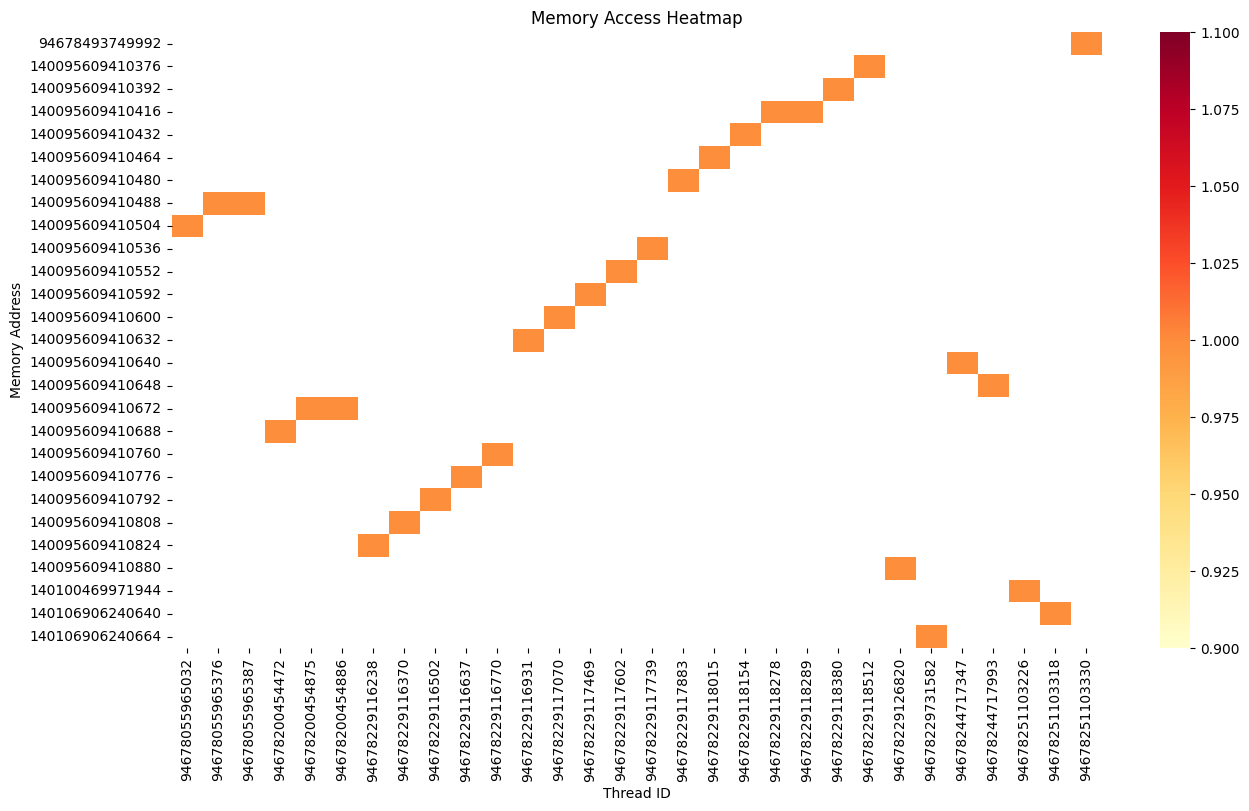

In [5]:
heat_data = pd.pivot_table(df, 
                          values='thread_id',  # можно использовать любую колонку как values
                          index='address',
                          columns='return_addr',
                          aggfunc='count')  # подсчет количества

# Создаем тепловую карту
plt.figure(figsize=(15, 8))
sns.heatmap(heat_data, cmap='YlOrRd')
plt.title('Memory Access Heatmap')
plt.xlabel('Thread ID')
plt.ylabel('Memory Address')
plt.show()

Слишком много уникальных значений return_address. Попробуем взять только 100 самых популярных.

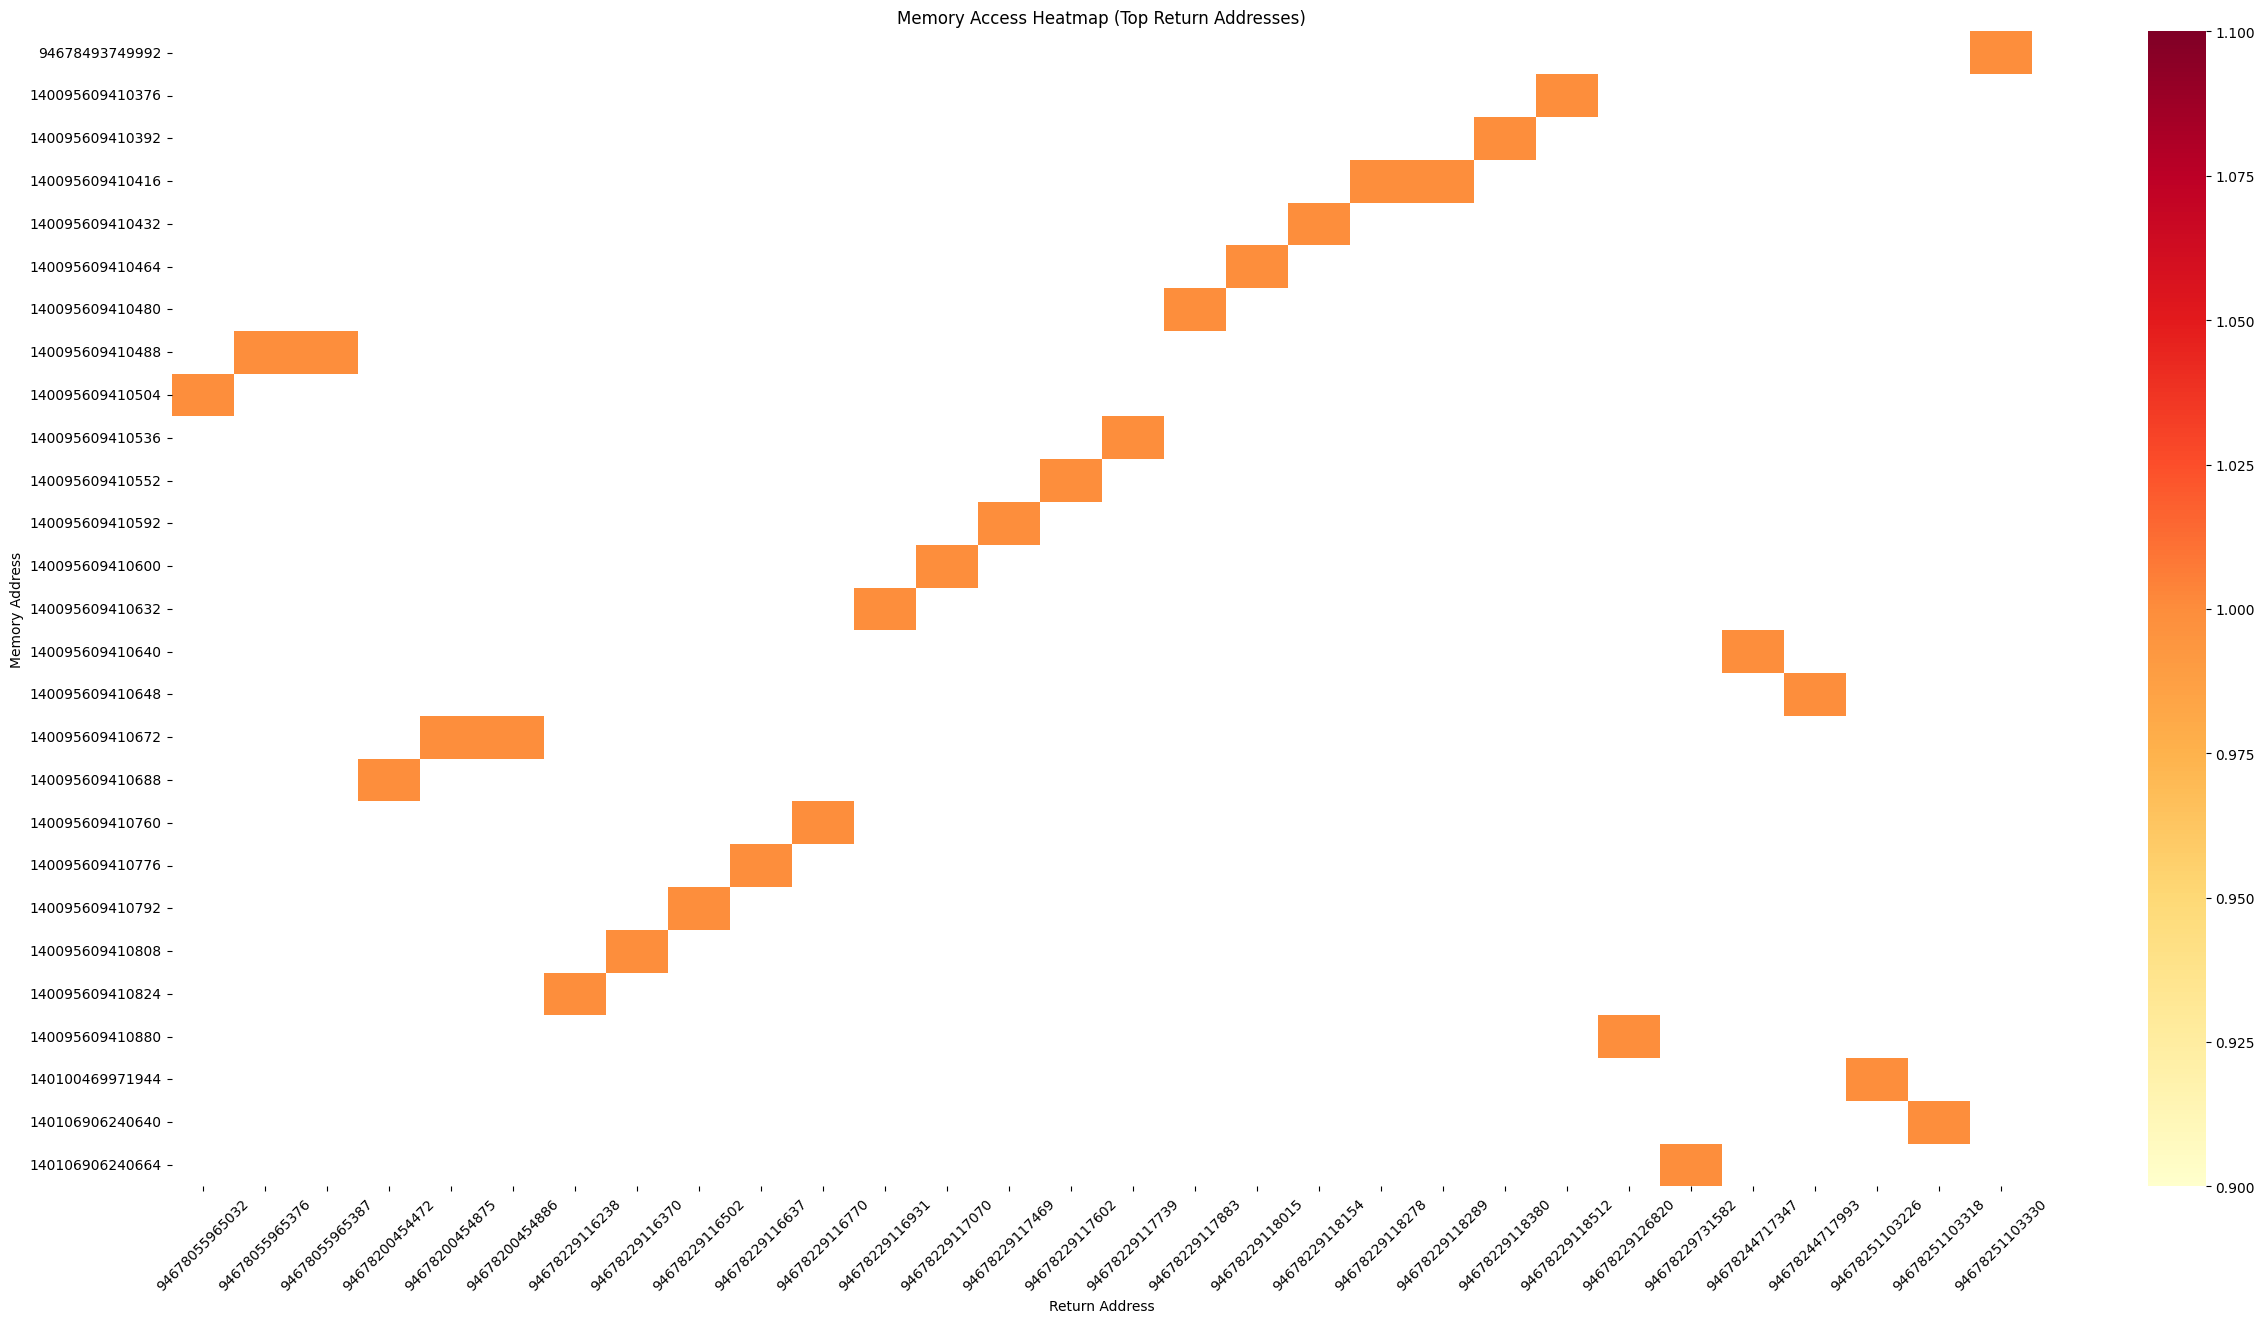

In [6]:
top_n = 100
frequent_addrs = df['return_addr'].value_counts().nlargest(top_n).index

# Фильтруем DataFrame
df_filtered = df[df['return_addr'].isin(frequent_addrs)]

# Создаем pivot table
heat_data = pd.pivot_table(df_filtered, 
                          values='thread_id',
                          index='address',
                          columns='return_addr',
                          aggfunc='count')

# Создаем тепловую карту
plt.figure(figsize=(30, 15))
sns.heatmap(heat_data, cmap='YlOrRd')
plt.title('Memory Access Heatmap (Top Return Addresses)')
plt.xlabel('Return Address')
plt.ylabel('Memory Address')
plt.xticks(rotation=45)
plt.show()

Heat-мапа доступов к памяти по адресам доступов и адресам возврата

In [7]:
import plotly.express as px

# Добавляем временную метку (порядковый номер)
df['timestamp'] = range(len(df))

fig = px.density_heatmap(
    df,
    x='timestamp',
    y='address',
    nbinsx=100,  # количество бинов по x
    nbinsy=100,  # количество бинов по y
    color_continuous_scale='Viridis'
)

fig.update_layout(
    title='Memory Access Density over Time',
    xaxis_title='Access Sequence',
    yaxis_title='Memory Address'
)
fig.show()


Здесь я пытался сделать временная диаграмму с помощью Plotly. Но получается неинформативная картинка. И из-за неё тормозит весь ipynb-ноутбук

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from hilbertcurve.hilbertcurve import HilbertCurve
import pandas as pd

def load_and_process_log(filename, chunk_size=1000000):
    chunks = pd.read_csv(filename, 
                        sep='\t', 
                        header=None,
                        names=['type', 'address', 'thread_id', 'timestamp'],
                        chunksize=chunk_size)
    
    addresses = []
    types = []
    
    for chunk in chunks:
        addresses.extend(chunk['address'].values)
        types.extend(chunk['type'].values)
        
    return addresses, types

def normalize_addresses(addresses):
    min_addr = min(addresses)
    max_addr = max(addresses)
    normalized = [(addr - min_addr) / (max_addr - min_addr) for addr in addresses]
    return normalized

def map_to_hilbert(normalized_addresses, p=8):
    hilbert = HilbertCurve(p, 2)
    max_distance = 2**(p*2) - 1  # Максимально допустимое значение
    points = []
    
    for addr in normalized_addresses:
        # Масштабируем к максимально допустимому значению
        scaled = int(addr * max_distance)
        # Убеждаемся, что значение не превышает максимально допустимое
        scaled = min(scaled, max_distance)
        coords = hilbert.points_from_distances([scaled])[0]
        points.append((coords[0], coords[1]))
    return points

def visualize_access_pattern(filename, sample_size=None):
    print("Loading data...")
    addresses, types = load_and_process_log(filename)
    
    if sample_size and sample_size < len(addresses):
        indices = np.random.choice(len(addresses), sample_size, replace=False)
        addresses = [addresses[i] for i in indices]
        types = [types[i] for i in indices]
    
    print("Normalizing addresses...")
    normalized_addresses = normalize_addresses(addresses)
    
    print("Mapping to Hilbert curve...")
    points = map_to_hilbert(normalized_addresses)
    
    print("Creating visualization...")
    plt.figure(figsize=(15, 15))
    
    # Создаем отдельные массивы для разных типов доступа
    load_points = [(x, y) for (x, y), t in zip(points, types) if t == 'l1' or 'l2' or 'l4' or 'l8' or 'l16']
    store_points = [(x, y) for (x, y), t in zip(points, types) if t == 's1' or 's2' or 's4' or 's8' or 's16']
    
    # Отображаем точки
    if load_points:
        load_x, load_y = zip(*load_points)
        plt.scatter(load_x, load_y, c='blue', alpha=0.6, label='Load (l8)', s=1)
    
    if store_points:
        store_x, store_y = zip(*store_points)
        plt.scatter(store_x, store_y, c='red', alpha=0.6, label='Store (s8)', s=1)
    
    plt.title('Memory Access Pattern (Hilbert Curve Mapping)')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.grid(True)
    plt.legend()
    
    plt.savefig('mini_memory_access_pattern.png', dpi=300, bbox_inches='tight')
    print("Visualization saved as 'memory_access_pattern.png'")
    plt.close()

# Использование
filename = "mini_example.log"
# Визуализируем случайную выборку из 100000 точек
visualize_access_pattern(filename)


Loading data...
Normalizing addresses...
Mapping to Hilbert curve...
Creating visualization...
Visualization saved as 'memory_access_pattern.png'


Какая-то неинформативная фигня

In [11]:
import numpy as np
from hilbertcurve.hilbertcurve import HilbertCurve
import matplotlib.pyplot as plt
from collections import defaultdict
import sys

# Размерность матрицы (можно настроить)
MATRIX_SIZE = 256  # 2^10, можно увеличить для большей детализации

def process_log_file(filename):
    # Словарь для подсчета обращений к каждому адресу
    address_counts = defaultdict(int)
    min_addr = float('inf')
    max_addr = 0
    
    # Читаем файл построчно
    with open(filename, 'r') as f:
        for line in f:
            parts = line.strip().split('\t')
            if len(parts) >= 2:
                addr = int(parts[1])
                # Фильтруем адреса меньше 140_000_000_000_000 -- чтобы что-то было видно
                if addr >= 140_000_000_000_000:
                    address_counts[addr] += 1
                    min_addr = min(min_addr, addr)
                    max_addr = max(max_addr, addr)
    
    return address_counts, min_addr, max_addr

def create_heatmap(address_counts, min_addr, max_addr):
    # Инициализируем кривую Гильберта
    p = int(np.ceil(np.log2(MATRIX_SIZE)))
    hilbert = HilbertCurve(p, 2)
    
    # Создаем матрицу для хитмапы
    matrix = np.zeros((MATRIX_SIZE, MATRIX_SIZE))
    
    # Нормализуем адреса в диапазон [0, MATRIX_SIZE^2 - 1)
    addr_range = max_addr - min_addr
    max_hilbert_index = (MATRIX_SIZE * MATRIX_SIZE) - 1
    
    for addr, count in address_counts.items():
        # Нормализуем адрес
        normalized_addr = int(((addr - min_addr) / addr_range) * max_hilbert_index)
        # Убеждаемся, что адрес не превышает максимально допустимое значение
        normalized_addr = min(normalized_addr, max_hilbert_index)
        
        try:
            # Получаем 2D координаты
            x, y = hilbert.point_from_distance(normalized_addr)
            # Проверяем, что координаты в допустимом диапазоне
            if x < MATRIX_SIZE and y < MATRIX_SIZE:
                matrix[x][y] = np.log1p(count)
        except ValueError:
            continue
    
    return matrix


def plot_heatmap(matrix):
    plt.figure(figsize=(12, 12))
    plt.imshow(matrix, cmap='Blues')
    plt.colorbar()
    plt.axis('off')
    plt.savefig('curve.png', dpi=300, bbox_inches='tight')
    plt.close()

filename = "example3.log"
print("Processing log file...")
address_counts, min_addr, max_addr = process_log_file(filename)

print("Creating heatmap...")
matrix = create_heatmap(address_counts, min_addr, max_addr)

print("Plotting...")
plot_heatmap(matrix)
print("Done! Output saved as 'curve.png'")

Processing log file...
Creating heatmap...
Plotting...
Done! Output saved as 'curve.png'


Получилось даже довольно неплохо. Видны области с горячей памятью

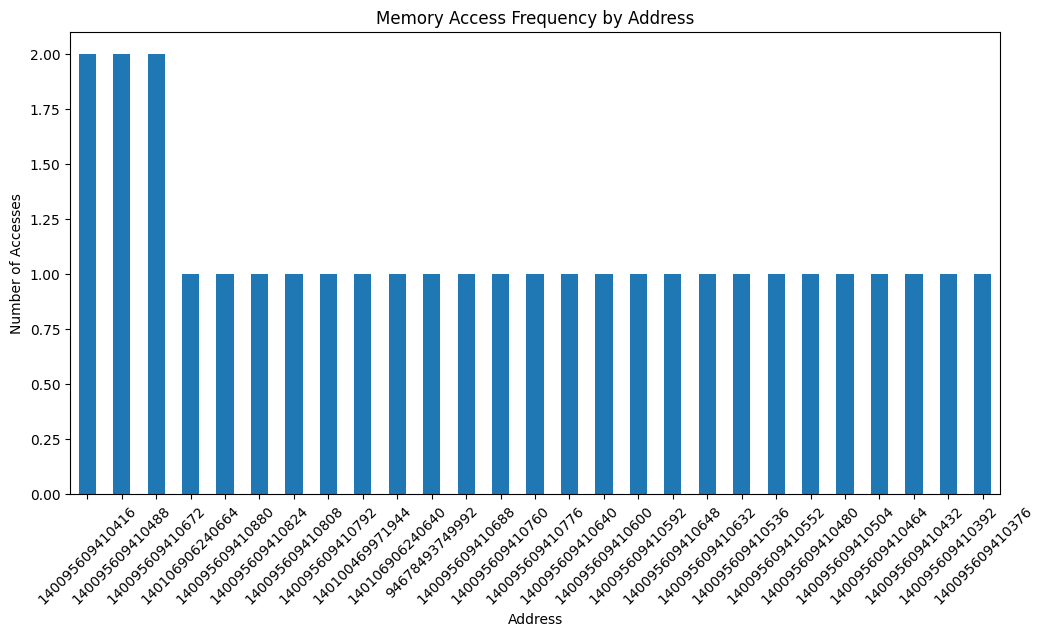

In [5]:
# Анализ повторяющихся паттернов
def analyze_patterns(df):
    # Считаем частоту доступа к каждому адресу
    address_counts = df['address'].value_counts()
    
    # Строим гистограмму
    plt.figure(figsize=(12, 6))
    address_counts.plot(kind='bar')
    plt.title('Memory Access Frequency by Address')
    plt.xlabel('Address')
    plt.ylabel('Number of Accesses')
    plt.xticks(rotation=45)
    plt.show()
    
    # Анализ последовательностей доступа
    # sequence_length = 5
    # sequences = df['address'].rolling(window=sequence_length).apply(tuple)
    # common_sequences = pd.Series(sequences.dropna()).value_counts().head(10)
    
    # return common_sequences

# Визуализация потоков -- не эскпориментировал с этим
def visualize_threads(df):
    plt.figure(figsize=(15, 8))
    for thread_id in df['thread_id'].unique():
        thread_data = df[df['thread_id'] == thread_id]
        plt.plot(thread_data.index, thread_data['address'], 
                label=f'Thread {thread_id}',
                marker='o', markersize=2)
    
    plt.title('Memory Access Patterns by Thread')
    plt.xlabel('Access Sequence')
    plt.ylabel('Memory Address')
    plt.legend()
    plt.show()

analyze_patterns(mini_df)

/var/folders/6v/fg49twt93q57w0frzbq9lh5w0000gn/T/ipykernel_53368/1484726306.py:45: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/var/folders/6v/fg49twt93q57w0frzbq9lh5w0000gn/T/ipykernel_53368/1484726306.py:46: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig('memory_access_patterns.png', dpi=300, bbox_inches='tight')
/Users/owltop/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


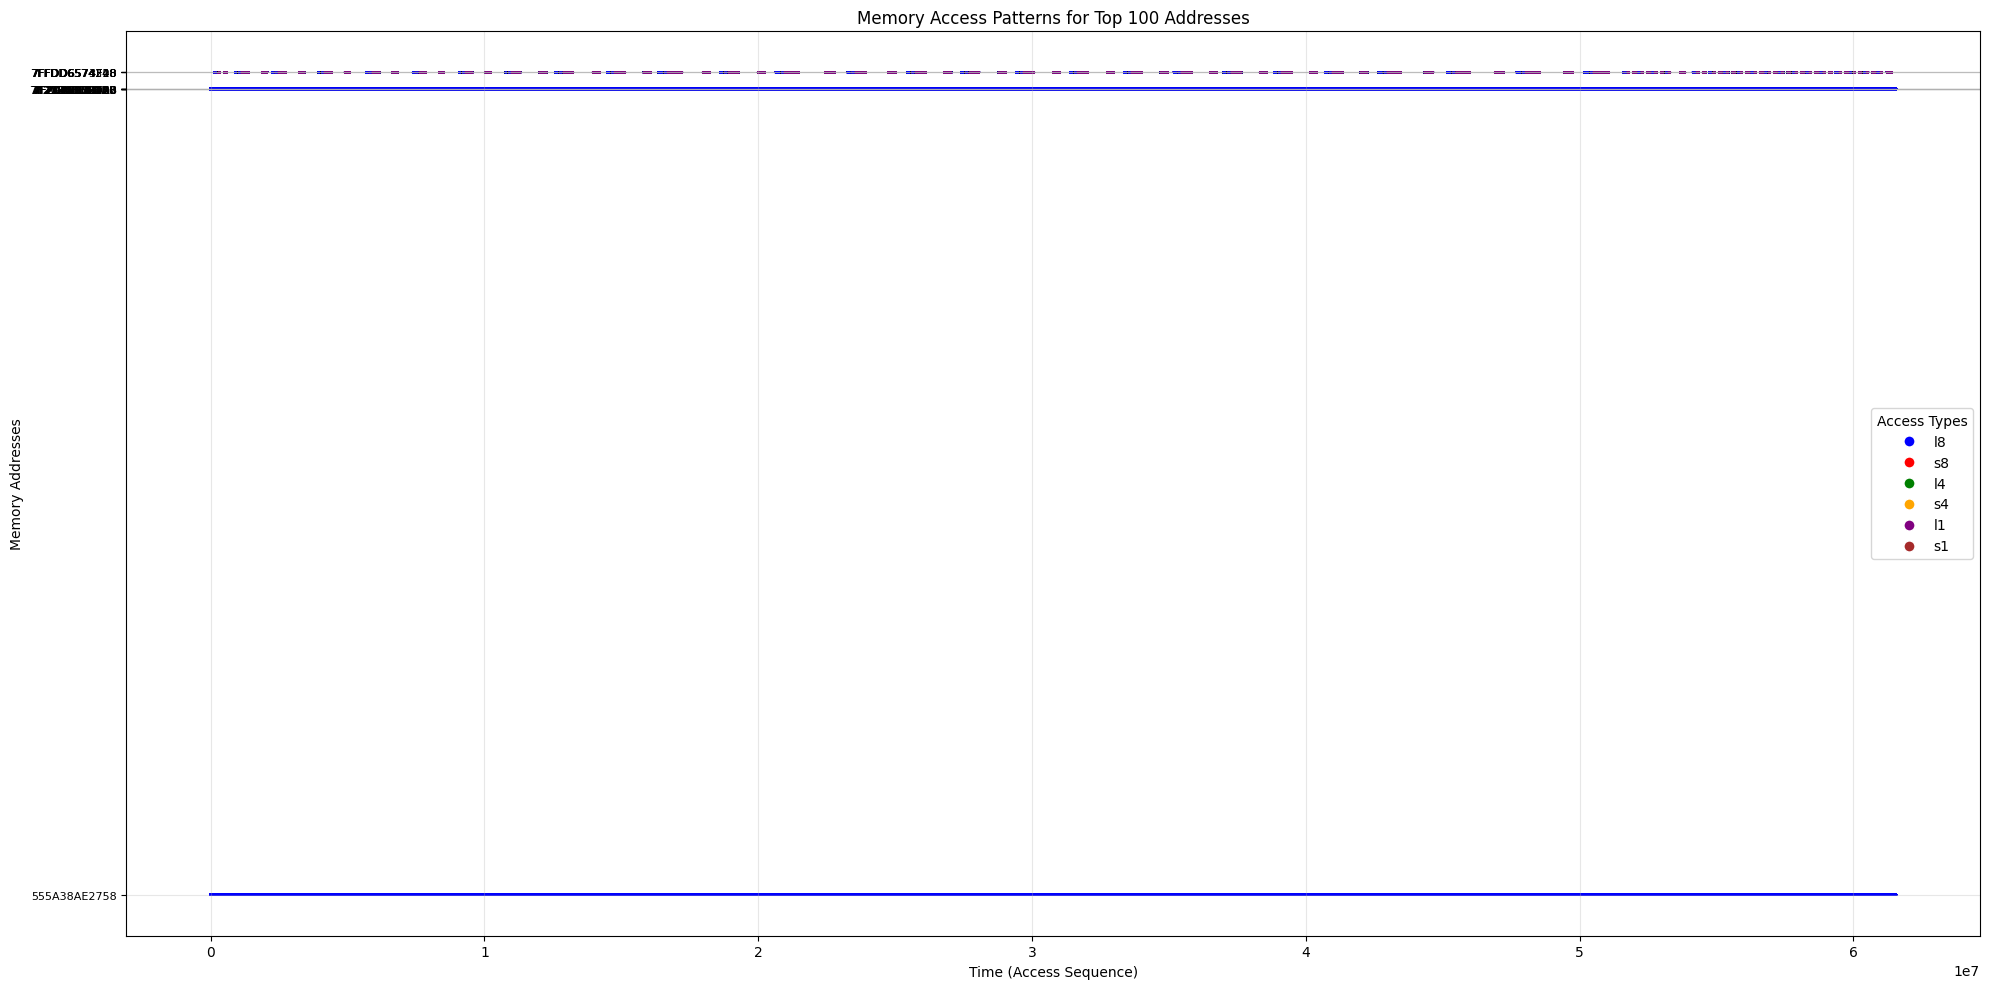

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


df_with_time = df
df_with_time['time'] = range(len(df))

top_addresses = df_with_time['address'].value_counts().head(100).index.tolist()

# 2. Отфильтруем данные только для этих адресов
filtered_df = df_with_time[df_with_time['address'].isin(top_addresses)]


# 4. Создадим диаграмму
plt.figure(figsize=(20, 10))

# Используем разные цвета для разных типов доступа (l8, s8 и т.д.)
colors = {'l8': 'blue', 's8': 'red', 'l4': 'green', 's4': 'orange', 
          'l1': 'purple', 's1': 'brown'}

# Создаем scatter plot
for addr in top_addresses:
    addr_data = filtered_df[filtered_df['address'] == addr]
    plt.scatter(addr_data['time'], 
               [addr] * len(addr_data),
               alpha=0.5,
               s=1,
               c=[colors.get(t, 'gray') for t in addr_data['type']])

plt.ylabel('Memory Addresses')
plt.xlabel('Time (Access Sequence)')
plt.title('Memory Access Patterns for Top 100 Addresses')

# Форматируем адреса для лучшей читаемости
plt.yticks(top_addresses[::5], [f"{addr:X}" for addr in top_addresses[::5]], fontsize=8)

# Добавляем легенду для типов доступа
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', 
                            markerfacecolor=color, label=access_type, markersize=8)
                  for access_type, color in colors.items()]
plt.legend(handles=legend_elements, title='Access Types')

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('memory_access_patterns.png', dpi=300, bbox_inches='tight')
plt.show()


Можно уменьшить размер точек (изменить параметр s)